# Non linear methods

## Neuronal Networks

First, we have to prepare the data :

In [ ]:
data <- read.csv(file.path("..", "data", "training_data.csv"))
data<-data[,-which(names(data) %in% c("SWEETORSOUR"))] 
data$Intensity<-as.numeric(as.factor(data$Intensity))
data<-data[ ,-which(apply(data, 2, var) == 0)] 

set.seed(199)
idx.train <- sample(nrow(data), nrow(data)*2/3)
data.train <- data[idx.train,]
datax.train<-data.train[,-which(names(data.train) %in% c("VALENCE.PLEASANTNESS"))]
datay.train<-data.train$VALENCE.PLEASANTNESS

data.test <- data[-idx.train,]
datax.test<-data.test[,-which(names(data.test) %in% c("VALENCE.PLEASANTNESS"))]
datay.test<-as.matrix(data.test$VALENCE.PLEASANTNESS)
#using more data samples

#verifiy if some new cols now have var 0
train.var<-(apply(datax.train, 2, var) != 0)
test.var<-(apply(datax.test,2,var)!=0)

datax.train<-datax.train[,which(test.var&train.var)] #take the same columns for both sets and only when both have var!=0
datax.test<-datax.test[,which(test.var&train.var)]
ncol(data.test)

datax.train<-as.matrix(datax.train)
datax.test<-as.matrix(datax.test)

We can choose to scale the data or not before applying the neuronal network : 

In [ ]:
get.scale <- function(scaled) {
  if ("scaled:center" %in% names(attributes(scaled))) {
      center <- attr(scaled, "scaled:center")
  } else {
      center <- rep(0, ncol(scaled))
  }
  if ("scaled:scale" %in% names(attributes(scaled))) {
      list(center, attr(scaled, "scaled:scale"))
  } else {
      list(center, rep(1., length(center)))
  }
}
scale.as <- function(x, scaled) {
  s <- get.scale(scaled)
  centered <- sweep(x, 2, s[[1]])
  sweep(centered, 2, s[[2]], FUN = "/")
}
y.unscale <- function(y, scaled) {
    s <- get.scale(scaled)
    y * s[[2]] + s[[1]]
}

#datax.train.sc<-scale(datax.train,center=T,scale=T)
#datay.train.sc<-scale(datay.train,center=T,scale=T)
#datax.test.sc<-scale.as(datax.test,datax.train.sc)
#datay.test.sc<-scale.as(datay.test,datay.train.sc)

In [1]:
library(keras)
use_condaenv("r-tensorflow")
set.seed(24)

#baseline model
model <- keras_model_sequential() %>% 
   layer_dense(units=64, activation="relu", input_shape=ncol(datax.train)) %>% 
   layer_dense(units=64, activation="relu", kernel_regularizer="l1") %>% 
   #layer_dense(units=32, activation="relu",kernel_regularizer="l1")%>%
   layer_dropout(rate=0.6)%>%
   layer_dense(units=32, activation = "relu") %>% 
   layer_dropout(rate=0.3) %>%                              #dropout layers prevent overfitting to the model
   layer_dense(units=1, activation="linear")


model %>% compile(
   loss = "mse",
   optimizer =  "adam", #this tunes the learning rate
 )

model %>% summary()
history<-model %>% fit(datax.train, 
                       datay.train,
                       epochs=30, #try to keep the training over the validation
                       callback=callback_early_stopping(monitor = "val_loss", patience = 10),
                       verbose = 0,
                       batch_size =100,      #reducing batch_size reduces the RMSE (but increases computation time)
                       validation_split = 0.2)
scores = model %>% evaluate(datax.train, datay.train, verbose = 0)

print(scores)

ypred <- model %>% predict(datax.train)
ypred.test<- model %>% predict(datax.test)

#RMSE
cat("Training RMSE:", sqrt(mean(ypred-datay.train)^2))
cat(" Test RMSE:", sqrt(mean(ypred.test-datay.test)^2))

#ypred.test.unscale<-y.unscale(ypred,datay.train.sc)
#loss=351, Training RMSE=18, Test RMSE=22
ypred.test
plot(history) #the loss doesn't decrease after epoch=20

ERROR: Error in ncol(datax.train): objet 'datax.train' introuvable


We created the model based in the whole data : 

In [ ]:
set.seed(24)
datax<-as.matrix(data[,-which(names(data) %in% c("VALENCE.PLEASANTNESS"))])
ncol(datax)
datay<-data$VALENCE.PLEASANTNESS

#baseline model
model_tot <- keras_model_sequential() %>% 
   layer_dense(units=64, activation="relu", input_shape=ncol(datax)) %>% 
   layer_dense(units=64, activation="relu", kernel_regularizer="l1") %>% 
   #layer_dense(units=32, activation="relu",kernel_regularizer="l1")%>%
   layer_dropout(rate=0.6)%>%
   layer_dense(units=32, activation = "relu") %>% 
   layer_dropout(rate=0.3) %>%                              #dropout layers prevent overfitting to the model
   layer_dense(units=1, activation="linear")


model_tot %>% compile(
   loss = "mse",
   optimizer =  "adam", 
 )

model_tot %>% summary()
history<-model_tot %>% fit(datax, 
                       datay,
                       epochs=30, #try to keep the training over the validation
                       callback=callback_early_stopping(monitor = "val_loss", patience = 10),
                       verbose = 0,
                       batch_size =100,      #reducing batch_size reduces the RMSE (but increases computation time)
                       validation_split = 0.2)
scores = model_tot %>% evaluate(datax, datay, verbose = 0)

ypred <- model_tot %>% predict(datax)
cat("  RMSE:", sqrt(mean(ypred-datay)^2))
print(scores)

We found a good test RMSE, so we decided to do a kaggle submission with this model : 

In [ ]:
data_test <- read.csv(file.path("..", "data", "test_data.csv"))
data_test <- data_test[,-1]

data_test$Intensity<-as.numeric(as.factor(data_test$Intensity)) 
data_test <-data_test[ ,-var]#remove the same predictors   
data_test_matrix <- as.matrix(data_test)


pred_test <- model_tot %>% predict(data_test_matrix)

#pred_test<-y.unscale(pred_test,data_test.sc)

data_sub <- read.csv(file.path("..", "data", "sampleSubmission.csv"))
data_sub <- data_sub[-69,]
data_sub$VALENCE.PLEASANTNESS <- pred_test
data_sub
write.csv(data_sub,file="Sub2.csv", row.names = FALSE)

We tried to create a model with convolutional layers (inspired from https://www.datatechnotes.com/2020/01/how-to-fit-regression-data-with-cnn.html) : 

In [ ]:
conv.nn <- keras_model_sequential()
datax.train = array(datax.train, dim = c(nrow(datax.train), ncol(datax.train), 1))
datax.test = array(datax.test,dim = c(nrow(datax.test), ncol(datax.test), 1))
#xtest = array(xtest, dim = c(nrow(xtest), 13, 1))
conv.nn %>%
   layer_conv_1d(filters = 64, kernel_size = 2, input_shape = c(ncol(datax.train),1), activation = "relu") %>%
   layer_flatten() %>%
   layer_dense(units=64, activation="relu") %>% 
   layer_dense(units=32, activation = "relu") %>% 
   layer_dense(units=1, activation="linear")

conv.nn %>% compile(
  loss = 'mse',
  optimizer = 'adam',
  metrics = c('accuracy')
)
history <- conv.nn %>% fit(
  datax.train, datay.train,
  epochs = 6, batch_size =8,      #reducing batch_size reduces the RMSE (but increases computation time)
  validation_split = 0.1, verbose=0
)
plot(history)

scores = conv.nn %>% evaluate(datax.train, datay.train, verbose = 0)
print(scores)

ypred = conv.nn %>% predict(datax.train)
ypred.test= conv.nn %>% predict(datax.test)
cat("Training RMSE:", sqrt(mean((ypred-datay.train)^2)))
cat("Test RMSE:", sqrt(mean((ypred.test-datay.test)^2)))
#training RMSE =21, test RMSE=23 worse than without convolutional  layer, stable after epochs =6

## Trees

First, we have to prepare the data and the libraries :

In [3]:
data <- read.csv(file.path("..", "data", "training_data.csv"))
data<-data[,-which(names(data) %in% c("SWEETORSOUR"))]
data$Intensity<-as.numeric(as.factor(data$Intensity)) 
data<-data[ ,( which(apply(data, 2, var) != 0))]

set.seed(199)
idx.train <- sample(nrow(data), nrow(data)/2)
data.train <- data[idx.train,]
data.test <- data[-idx.train,]

data.train.x <- data.train[,-which(names(data.train) %in% c("VALENCE.PLEASANTNESS"))]
data.train.x.matrix <- as.matrix((model.matrix(~.-1, data.train.x)))
data.train.y <- data.train$VALENCE.PLEASANTNESS

data.test.x <- data.test[,-which(names(data.test) %in% c("VALENCE.PLEASANTNESS"))]
data.test.x.matrix <- as.matrix((model.matrix(~.-1, data.test.x)))
data.test.y <- data.test$VALENCE.PLEASANTNESS

In [4]:
library(tree)
library(randomForest)
library(xgboost)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


### Simple tree regression

As a baseline model and to see the result of the simplest model, we perform a simple tree regression on the data set, taking into account all the predictors whose variance is not equal to zero :

In [5]:
tree.data.train <- tree(VALENCE.PLEASANTNESS ~ ., data = data.train)
summary(tree.data.train)

pred.test <- predict(tree.data.train, newdata = data.test.x)
MSE.test <- mean((pred.test - data.test.y)^2)
RMSE.test <- sqrt(MSE.test)
print(paste0('test MSE :', MSE.test))
print(paste0('test RMSE :', RMSE.test))

pred.train <- predict(tree.data.train,data.train.x)
MSE.train <- mean((pred.train - data.train.y)^2)
RMSE.train <- sqrt(MSE.train)
print(paste0('train MSE :', MSE.train))
print(paste0('train RMSE :', RMSE.train))


Regression tree:
tree(formula = VALENCE.PLEASANTNESS ~ ., data = data.train)
Variables actually used in tree construction:
 [1] "Eig04_EA.ri."           "Mor21v"                 "GNar"                  
 [4] "Mor10e"                 "P_VSA_MR_7"             "B04.C.S."              
 [7] "P_VSA_LogP_2"           "R6s."                   "HATS6p"                
[10] "GATS4m"                 "Mor10s"                 "Mor07p"                
[13] "HATS7s"                 "JGI2"                   "Mor03m"                
[16] "MATS4m"                 "GATS5e"                 "Mor27u"                
[19] "G3u"                    "complexity.from.pubmed" "DLS_cons"              
[22] "RTs"                    "RDF045s"                "G3e"                   
Number of terminal nodes:  25 
Residual mean deviance:  220.8 = 72640 / 329 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-41.6200  -9.1760   0.0625   0.0000   8.3780  50.9100 

[1] "test MSE :756.039616713886"
[1] "test RMSE :27.4961745832741"
[1] "train MSE :205.210269500844"
[1] "train RMSE :14.325162110805"


The test RMSE that we found is quite high, so we have to try another method to decrease this test RMSE. We tried to do cross validation on pruned trees but the test RMSE is not better than the RMSE of simple regression trees.

### Bagging

In [6]:
set.seed(1)
m <- 3028 # in Bagging, we consider all the predictors as split candidates
bag <- randomForest(VALENCE.PLEASANTNESS ~ ., data = data.train, mtry = m) # ntree = 500 by default
pred.bag.test <- predict(bag, newdata = data.test.x)
MSE.test = mean((pred.bag.test - data.test.y)^2)
RMSE.test = sqrt(MSE.test)
print(paste0('test MSE :', MSE.test))
print(paste0('test RMSE :', RMSE.test))

pred.bag.train <- predict(bag,data.train.x)
MSE.train = mean((pred.bag.train - data.train.y)^2)
RMSE.train = sqrt(MSE.train)
print(paste0('train MSE :', MSE.train))
print(paste0('train RMSE :', RMSE.train))

[1] "test MSE :517.367327952118"
[1] "test RMSE :22.7457100999753"
[1] "train MSE :103.219968042396"
[1] "train RMSE :10.1597228329515"


The test RMSE considerably decreased ; so, bagging method is more efficient that simple tree regression. Random forest method is known to be usually more efficient than bagging whose problem is highly correlated fits. Let's try it :

### Random Forest

We chose to compare the results of random forest for m between 50 and 120 because the typical choice of m is sqrt(nb of parameters) :

[1] "m that give the min test RMSE is :106"
[1] "test RMSE min :22.8933439498098"
[1] "train RMSE min :11.8907143599555"


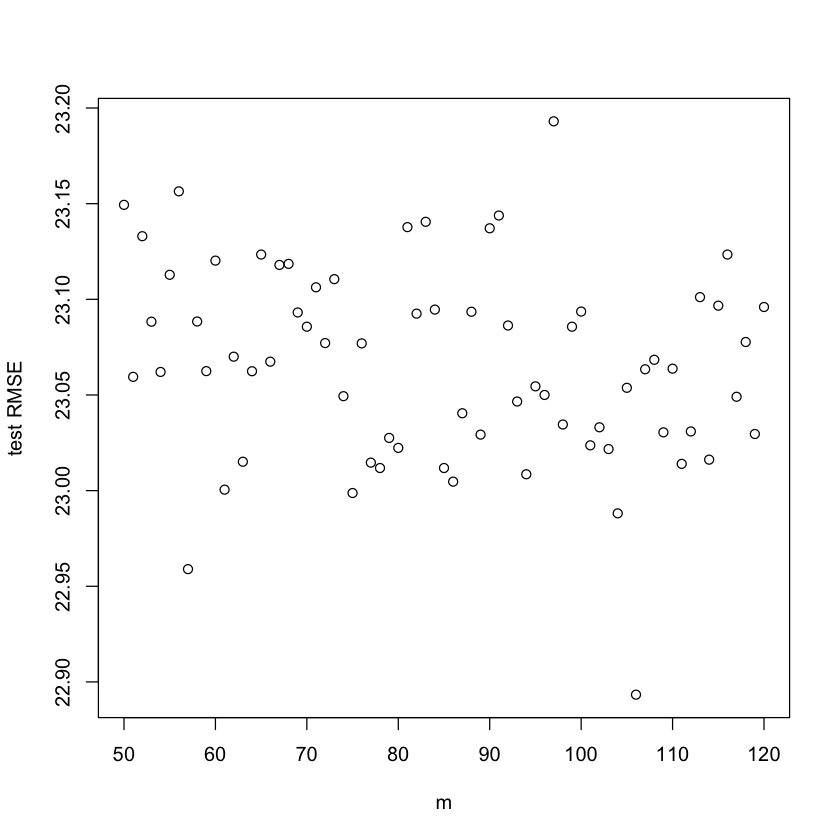

In [7]:
set.seed(5)
random_forest <- function(m,data.train,data.test) {
    rf <- randomForest(VALENCE.PLEASANTNESS ~ ., data = data.train, mtry = m) #ntree = 500 by default
    pred <- predict(rf, data.test[,-which(names(data.train) %in% c("VALENCE.PLEASANTNESS"))])
    MSE = mean((pred - data.test$VALENCE.PLEASANTNESS)^2)
    sqrt(MSE)
}

RMSE.test <- sapply(50:120, random_forest, data.train, data.test)
plot(50:120,RMSE.test,xlab='m',ylab='test RMSE')
n <- which.min(RMSE.test) + 49 #Change the 49 if we change the intervall of m 50:120
print(paste0('m that give the min test RMSE is :', n)) 
print(paste0('test RMSE min :', RMSE.test[which.min(RMSE.test)]))

rf <- randomForest(VALENCE.PLEASANTNESS ~ ., data = data.train, mtry = n+49) #Change the 49 if we change the intervall of m 50:120
pred.train <- predict(rf, data.train.x)
RMSE.train <- sqrt(mean((pred.train-data.train.y)^2))
print(paste0('train RMSE min :', RMSE.train))

We found that the m that gives the lowest test error is 106. The test error is slighty the same as the bagging method. Let's try boosting to see if we can improve the test RMSE :

### Boosting

First, we selected the lambda (shrinkage parameter) that gives the lowest test error : 

[1] "test RMSE : 22.4260386806041"
[1] "lambda min test :0.00316227766016838"
[1] "train RMSE with the lambda min test : 14.3740302778053"
[1] "train min RMSE : 3.30660293636581"
[1] "lambda min train : 0.398107170553497"


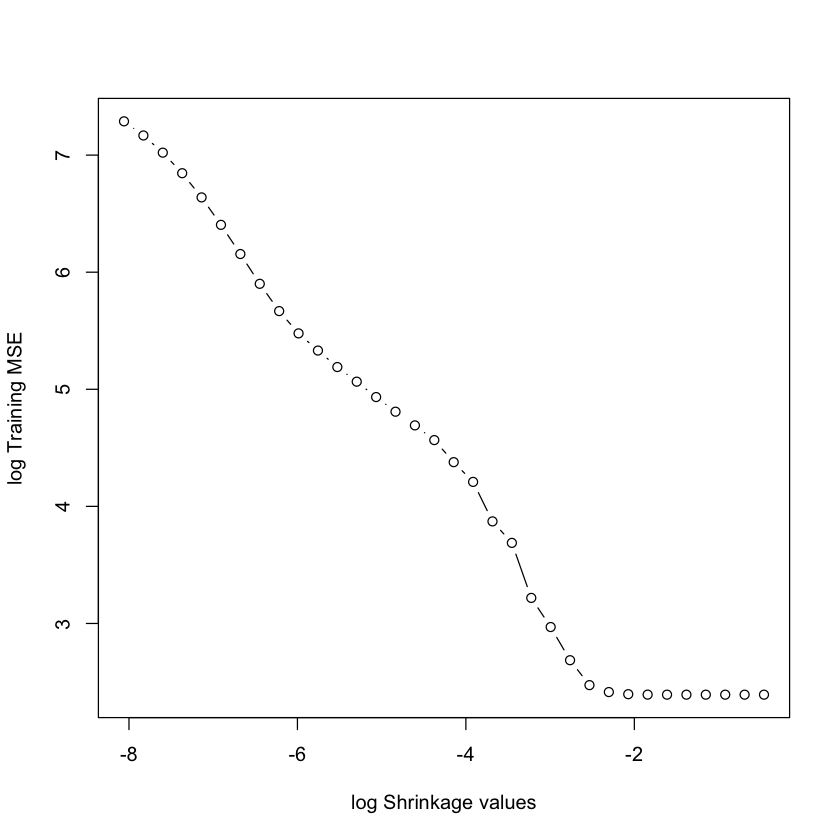

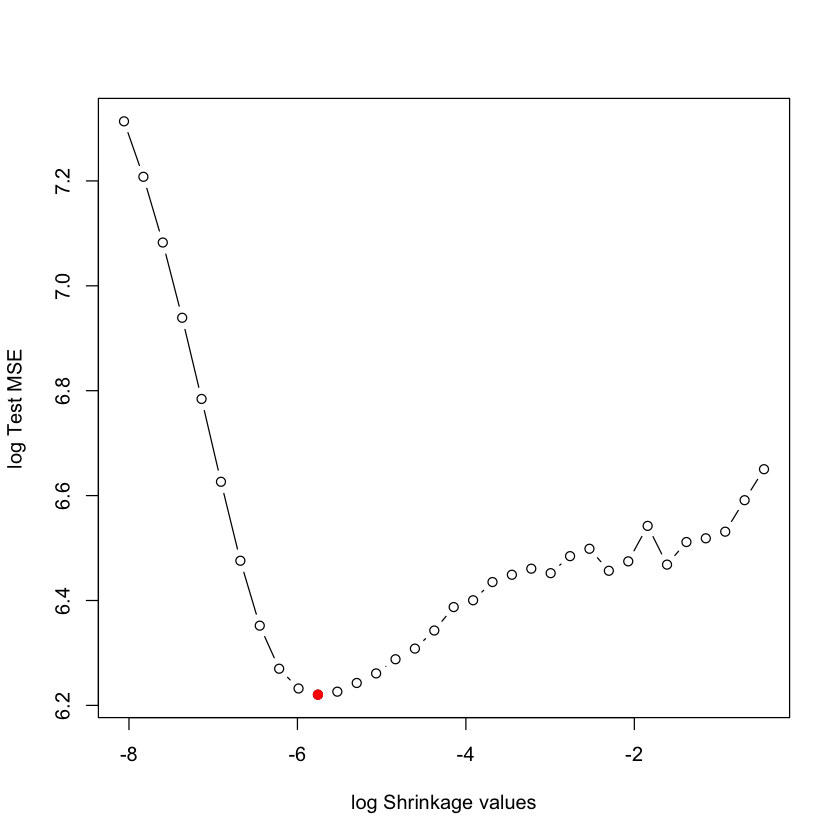

In [8]:
set.seed(3)
pows <- seq(-3.5, -0.2, by = 0.1)
lambdas <- 10^pows
train.err <- rep(NA, length(lambdas))
test.err <- rep(NA, length(lambdas))
for (i in 1:length(lambdas)) {
  boost <- xgboost(data.train.x.matrix,
                           label=data.train.y,
                           eta=lambdas[i],
                           objective="reg:squarederror",
                           max.depth=3,
                           nrounds=1000,
                           verbose = 0)
  pred.train <- predict(boost, data.train.x.matrix)
  pred.test <- predict(boost, data.test.x.matrix)
  train.err[i] <- mean((pred.train - data.train.y)^2)
  test.err[i] <- mean((pred.test - data.test.y)^2)
}

MSEmin.test <- min(test.err)
lambdamin.test <- lambdas[which.min(test.err)]
MSE.train <- train.err[which.min(test.err)]
MSEmin.train <- min(train.err)
lambdamin.train <- lambdas[which.min(train.err)]

print(paste0('test RMSE : ', sqrt(MSEmin.test)))
print(paste0('lambda min test :', lambdamin.test))
print(paste0('train RMSE with the lambda min test : ', sqrt(MSE.train)))
print(paste0('train min RMSE : ', sqrt(MSEmin.train)))
print(paste0('lambda min train : ', lambdamin.train))

plot(log(lambdas), log(train.err), type="b", xlab="log Shrinkage values", ylab="log Training MSE")
plot(log(lambdas), log(test.err), type="b", xlab="log Shrinkage values", ylab="log Test MSE")
points(log(lambdas[which.min(test.err)]), log(min(test.err)), col="red", pch=19)

We can see that the test RMSE is better, so we can try to still improve this method.

To improve the method we can do cross validation to select the optimal number of rounds : 

##### xgb.cv 6-folds
    iter train_rmse_mean train_rmse_std test_rmse_mean test_rmse_std
       1        48.98617      0.3524666       48.96600      1.790120
       2        48.85708      0.3523474       48.84425      1.789703
       3        48.72813      0.3521329       48.72223      1.789485
       4        48.59996      0.3520204       48.60144      1.789047
       5        48.47193      0.3518089       48.48039      1.788818
---                                                                 
    1496        11.89704      0.3147232       23.24164      1.151748
    1497        11.89468      0.3150516       23.24187      1.151921
    1498        11.89240      0.3153672       23.24270      1.152625
    1499        11.88996      0.3155262       23.24261      1.152408
    1500        11.88765      0.3155635       23.24293      1.152211
[1] "the best iteration is : 1012"
[1] "the best CV RMSE is : 23.0130048333333"


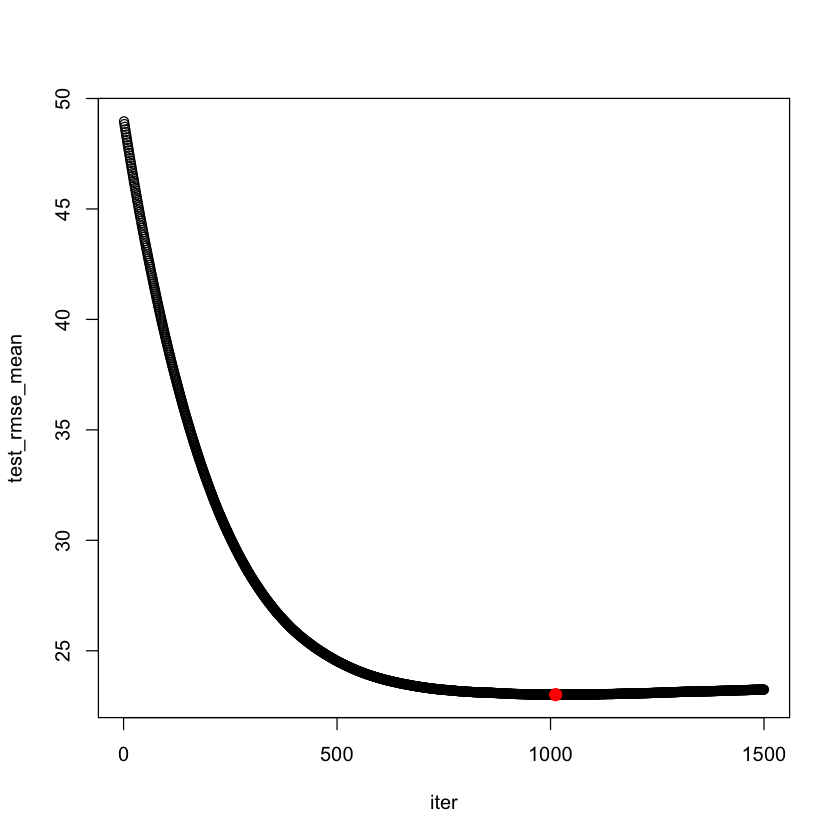

In [10]:
set.seed(1)
boost.cv <- xgb.cv(params = list(eta=lambdamin.test, objective="reg:squarederror",max.depth=3),
                     data = data.train.x.matrix,
                     label = data.train.y,
                     nrounds = 1500,
                     nfold = 6,
                     verbose = 0)
print(boost.cv)

df <- data.frame(X = boost.cv$evaluation_log[,1], Y=boost.cv$evaluation_log[,4])
plot(df)
df_m <- as.matrix(df)
min <- which.min(df_m[,2])
print(paste0('the best iteration is : ',df_m[,1][min]))
print(paste0('the best CV RMSE is : ',df_m[,2][min]))
points(df_m[,1][min],df_m[,2][min], col = "red", cex = 2, pch = 20)

Now, we have the best shrinkage parameter and the best number of rounds, so we can compute the best boosting model :

In [11]:
best.boost <- xgboost(data.train.x.matrix,
                           label=data.train.y,
                           eta=lambdamin.test,
                           objective="reg:squarederror",
                           max.depth=3,
                           nrounds=df_m[,1][min],
                           verbose = 0)

pred.train <- predict(best.boost, data.train.x.matrix)
pred.test <- predict(best.boost, data.test.x.matrix)
RMSE.train <- sqrt(mean((pred.train - data.train.y)^2))
RMSE.test <- sqrt(mean((pred.test - data.test.y)^2))
print(paste0('the best train RMSE is : ',RMSE.train))
print(paste0('the best test RMSE is : ',RMSE.test))

[1] "the best train RMSE is : 14.3238345862892"
[1] "the best test RMSE is : 22.422066638086"


The test RMSE is slighty better.
By computing the importance matrix, we can see which variables appear to be the most important predictors in the boosted model : 

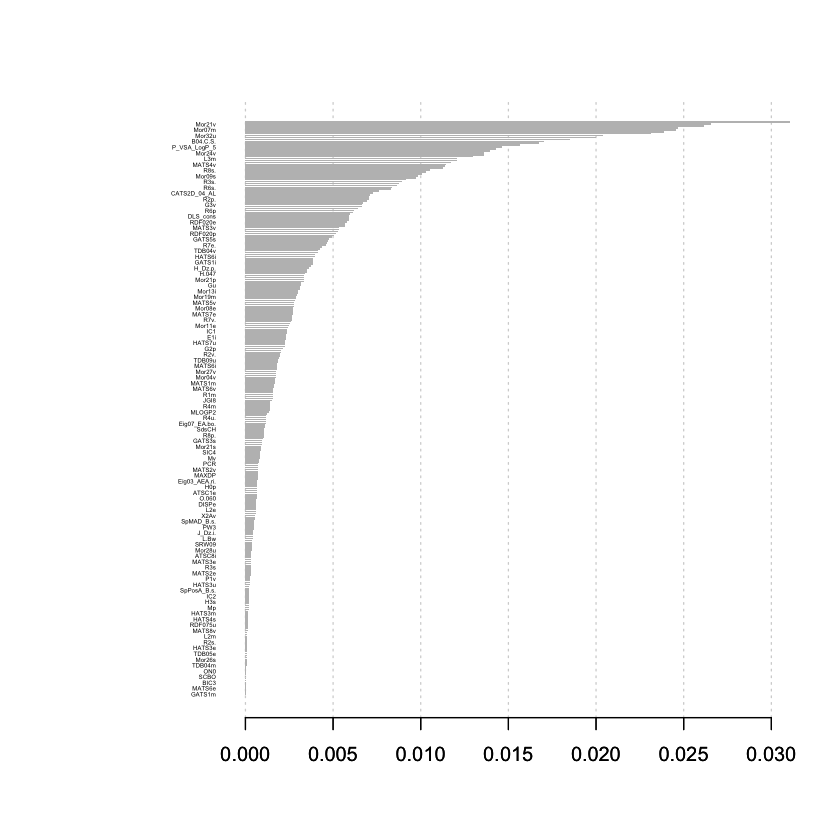

In [13]:
importance_matrix <- xgb.importance(model=best.boost)
xgb.plot.importance(importance_matrix=importance_matrix)

So, we did a kaggle submission with this model (best.boost) : 

In [12]:
data_training <- read.csv(file.path("..", "data", "training_data.csv"))
data_training$Intensity<-as.numeric(as.factor(data_training$Intensity))
data_training <- data_training[,-which(names(data_training) %in% c("VALENCE.PLEASANTNESS"))]
data_training <-data_training[,-which(names(data_training) %in% c("SWEETORSOUR"))]

data_test <- read.csv(file.path("..", "data", "test_data.csv"))
data_test <- data_test[,-1]
data_test$Intensity<-as.numeric(as.factor(data_test$Intensity)) 
data_test <-data_test[ ,( which(apply(data_training, 2, var) != 0))]#remove the same predictors   
data_test_matrix <- as.matrix((model.matrix(~.-1, data_test)))
#dim(data_test)
#dim(data.train.x)
pred_test <- predict(best.boost,data_test_matrix)
#pred_test
data_sub <- read.csv(file.path("..", "data", "sampleSubmission.csv"))
data_sub <- data_sub[-69,]
data_sub$VALENCE.PLEASANTNESS <- pred_test
#data_sub
write.csv(data_sub,file="Sub1.csv", row.names = FALSE)